## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e5_patch
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
## malign and benign aee reverted !!!!!!!!!!!!!

diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

In [5]:
print('Malign: ', df['diagnosis'].value_counts()[0])
print('Benign: ', df['diagnosis'].value_counts()[1])

Malign:  305
Benign:  195


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.390000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,0.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


In [10]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0]
non_fraud_df = df.loc[df['diagnosis'] == 1][:195]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
393,903516,1.0,21.61,22.28,144.40,1407.0,0.11670,0.20870,0.28100,0.15620,...,2081.0,0.15020,0.5717,0.70530,0.24220,0.3828,0.10070,NaN,8,22
173,871641,0.0,11.08,14.71,70.21,372.7,0.10060,0.05743,0.02363,0.02583,...,396.5,0.12160,0.0824,0.03938,0.04306,0.1902,0.07313,NaN,1,29
141,869104,1.0,16.11,18.05,105.10,813.0,0.09721,0.11370,0.09447,0.05943,...,1233.0,0.13140,0.2236,0.28020,0.12160,0.2792,0.08158,NaN,0,30
338,897880,0.0,10.05,17.53,64.41,310.8,0.10070,0.07326,0.02511,0.01775,...,384.0,0.14020,0.1402,0.10550,0.06499,0.2894,0.07664,NaN,0,30
243,88411702,0.0,13.75,23.77,88.54,590.0,0.08043,0.06807,0.04697,0.02344,...,706.0,0.09368,0.1442,0.13590,0.06106,0.2663,0.06321,NaN,0,30


In [11]:
sub_sample_corr = sub_sample_df.corr()

In [12]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [13]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 8))

(['concave points_worst', 'under_average', 'perimeter_worst', 'smoothness_se', 'radius_worst', 'symmetry_se', 'concave points_mean', 'texture_se'], [0.7943760186139828, -0.35661340233422306, 0.7802775126194339, -0.02978995032157478, 0.7740326821281189, -0.0001890815372350071, 0.7727922399366887, 0.00337097441705968])


In [14]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [15]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
49,0.440550,1.0,0.394108,0.143110,0.420366,0.207853,0.168191,0.276970
286,0.396907,1.0,0.367038,0.215837,0.367370,0.237112,0.188419,0.284545
133,0.472165,1.0,0.455016,0.167588,0.485572,0.211400,0.294881,0.166940
358,0.163643,1.0,0.259833,0.351108,0.276942,0.359341,0.118340,0.245650
476,0.460137,1.0,0.446258,0.131931,0.456437,0.203927,0.151988,0.208393


In [16]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
0,0.912027,0.566667,0.734873,0.205557,0.704218,0.380367,0.731113,0.185322
369,0.835739,0.700000,0.776274,0.127787,0.767481,0.192274,0.746024,0.143275
132,0.450859,1.000000,0.516322,0.156666,0.540233,0.194427,0.278976,0.258956
300,0.680412,0.900000,0.681131,0.194539,0.719478,0.238632,0.527833,0.237666
353,0.524399,1.000000,0.482484,0.337938,0.513596,0.268524,0.325696,0.308291


In [17]:
input_data=malign.to_numpy()
input_data

array([[0.44054983, 1.        , 0.39410828, ..., 0.20785307, 0.16819085,
        0.27697032],
       [0.39690722, 1.        , 0.36703822, ..., 0.2371121 , 0.18841948,
        0.28454452],
       [0.47216495, 1.        , 0.45501592, ..., 0.21139962, 0.29488072,
        0.16693961],
       ...,
       [0.29505155, 1.        , 0.38248408, ..., 0.16782774, 0.08563618,
        0.18902764],
       [0.18329897, 0.96666667, 0.28535032, ..., 0.41557948, 0.08836978,
        0.29150461],
       [0.22707904, 1.        , 0.38339968, ..., 0.33337555, 0.09358847,
        0.26591607]])

## Training node

In [18]:
shots = 2500
nr_trash=2
nr_latent=2
nr_ent=0

trash_qubits1=[i for i in range(nr_trash)]
latent_qubits1=[i for i in range(nr_trash,nr_trash+nr_latent)]
trash_qubits2=[i for i in range(nr_trash+nr_latent,2*nr_trash+nr_latent)]
latent_qubits2=[i for i in range(2*nr_trash+nr_latent,2*(nr_trash+nr_latent))]
aux_qubits=[i for i in range(2*(nr_trash+nr_latent),2*(nr_trash+nr_latent)+2*nr_trash)]
swap_qubit=[2*(nr_trash+nr_latent)+2*nr_trash]

qubits=[*trash_qubits1, *latent_qubits1, *trash_qubits2, *latent_qubits2, *aux_qubits, *swap_qubit]

print("Qubits:", qubits)

#set up the device 
dev = qml.device("default.qubit", wires=qubits)


Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [19]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])
    qml.CNOT(wires=[latent_qubits1[0],trash_qubits2[0]])
    qml.CNOT(wires=[latent_qubits2[0],trash_qubits1[0]])
    
    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

## Training parameters 

In [20]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [21]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [22]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [23]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [24]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [25]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_16228/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [26]:
batches=iterate_batches(training_data, batch_size)

In [27]:
X_training = training_data
X_tes = test_data

In [28]:
nr_encod_qubits = nr_trash + nr_latent
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = [np.random.uniform(size=(1, nr_par_encoder), requires_grad=True),np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)]

In [29]:
encoder_params

[tensor([[0.09075912, 0.43083438, 0.61104191, 0.98140128, 0.25916799,
          0.19127658, 0.73801206, 0.75994369, 0.49570623, 0.22337904,
          0.38290263, 0.979896  , 0.76047812, 0.56600444, 0.73228928,
          0.93751677, 0.51956001, 0.04816204, 0.16931909, 0.534288  ,
          0.13641588, 0.80369072, 0.8293342 , 0.65430993, 0.14405095,
          0.27119131, 0.55490971, 0.29333833, 0.9997208 , 0.65201246,
          0.58802442, 0.19784574, 0.91822301, 0.41495821, 0.82805115,
          0.42098419, 0.03064296, 0.79588406, 0.38978271, 0.16030516,
          0.54942394, 0.49227646, 0.07936756, 0.88438489, 0.4513883 ,
          0.87050712, 0.02449582, 0.94120391, 0.85761813, 0.56772217,
          0.66257483, 0.82942069, 0.50472169, 0.25880231, 0.44968381,
          0.85549735, 0.36922135, 0.27193812, 0.59981726, 0.58904543,
          0.49931935, 0.99603338, 0.05688344, 0.9712426 , 0.85166285,
          0.33571091, 0.60787448, 0.02162765, 0.92907753, 0.7058599 ,
          0.80389319

In [30]:
encoder_params[0]

tensor([[0.09075912, 0.43083438, 0.61104191, 0.98140128, 0.25916799,
         0.19127658, 0.73801206, 0.75994369, 0.49570623, 0.22337904,
         0.38290263, 0.979896  , 0.76047812, 0.56600444, 0.73228928,
         0.93751677, 0.51956001, 0.04816204, 0.16931909, 0.534288  ,
         0.13641588, 0.80369072, 0.8293342 , 0.65430993, 0.14405095,
         0.27119131, 0.55490971, 0.29333833, 0.9997208 , 0.65201246,
         0.58802442, 0.19784574, 0.91822301, 0.41495821, 0.82805115,
         0.42098419, 0.03064296, 0.79588406, 0.38978271, 0.16030516,
         0.54942394, 0.49227646, 0.07936756, 0.88438489, 0.4513883 ,
         0.87050712, 0.02449582, 0.94120391, 0.85761813, 0.56772217,
         0.66257483, 0.82942069, 0.50472169, 0.25880231, 0.44968381,
         0.85549735, 0.36922135, 0.27193812, 0.59981726, 0.58904543,
         0.49931935, 0.99603338, 0.05688344, 0.9712426 , 0.85166285,
         0.33571091, 0.60787448, 0.02162765, 0.92907753, 0.7058599 ,
         0.80389319, 0.47483617, 0

###  training

In [31]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [32]:

loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("benign fid:{}".format(b_fidel))
        
        """
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-SelectedFeautures/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
        """

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(
C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.7001964166363608 | Fidelity:0.5882618397430397
Test-Epoch:0 | Loss:1.7027630661825996 | Fidelity:0.5873531158083523
benign fid:0.5858936051505066
Epoch:5 | Loss:1.3535133196643896 | Fidelity:0.7389725100041398
Test-Epoch:5 | Loss:1.3538413315024203 | Fidelity:0.738755298089553
benign fid:0.7091491362904917
Epoch:10 | Loss:1.2429724008097722 | Fidelity:0.8046708143127466
Test-Epoch:10 | Loss:1.2417048387636707 | Fidelity:0.8054316796743306
benign fid:0.7622107531485887
Epoch:15 | Loss:1.19891603625708 | Fidelity:0.8342311024576119
Test-Epoch:15 | Loss:1.1963537307529575 | Fidelity:0.8359468897273952
benign fid:0.7813937301644875
Epoch:20 | Loss:1.1801478264470295 | Fidelity:0.8475044664236261
Test-Epoch:20 | Loss:1.1766340722361306 | Fidelity:0.8499530407009908
benign fid:0.7873665967189715
Epoch:25 | Loss:1.1725992455550873 | Fidelity:0.8529689910103918
Test-Epoch:25 | Loss:1.1684613529032637 | Fidelity:0.8558979835902781
benign fid:0.7888332636727862
Epoch:30 | Loss:1

benign fid:0.7974740712920172
Epoch:250 | Loss:1.161914345389392 | Fidelity:0.86078428244283
Test-Epoch:250 | Loss:1.158131447865189 | Fidelity:0.8635127677450742
benign fid:0.7979767452548617
Epoch:255 | Loss:1.1618968448635316 | Fidelity:0.8608001606873685
Test-Epoch:255 | Loss:1.1580291072871152 | Fidelity:0.863589943796076
benign fid:0.797467443810489
Epoch:260 | Loss:1.1618825649793292 | Fidelity:0.8608109685436931
Test-Epoch:260 | Loss:1.1580230601259225 | Fidelity:0.8635948176345788
benign fid:0.797371086468798
Epoch:265 | Loss:1.1618949526411764 | Fidelity:0.860798462995461
Test-Epoch:265 | Loss:1.1581280469443809 | Fidelity:0.8635147560069962
benign fid:0.7982243603937011
Epoch:270 | Loss:1.1618971365599537 | Fidelity:0.8608062393535847
Test-Epoch:270 | Loss:1.1578728232573086 | Fidelity:0.863709109396778
benign fid:0.7963801552499149
Epoch:275 | Loss:1.161882762241982 | Fidelity:0.8608074333912437
Test-Epoch:275 | Loss:1.158075244033647 | Fidelity:0.8635544295938136
benign fi

Test-Epoch:495 | Loss:1.1577441554330763 | Fidelity:0.8638061542404104
benign fid:0.7972551678152525


## Rezults

In [33]:
import matplotlib.pyplot as plt

fidelity: 0.8609424846861528


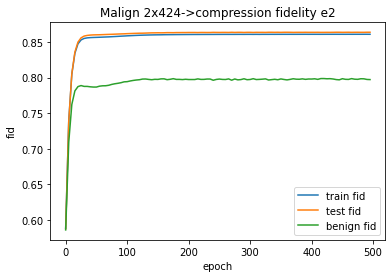

In [34]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="benign fid")

plt.legend()
plt.title("Malign 2x424->compression fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.1617147474032532


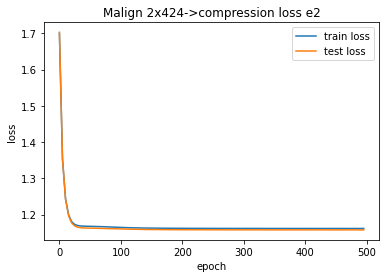

In [35]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Malign 2x424->compression loss e2",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

## Benign performance 

In [37]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


Benign results:
fidelity= 0.7983760321522455
loss= 1.2550159677852606


## Classifyer

In [38]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.6833258225888227
0.8617865939720931


In [39]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.8226940476819373
0.886700458890945


In [40]:
beningn_flist

[0.7295445725582378,
 0.7496433166313937,
 0.8340177692980565,
 0.7839552440922116,
 0.8221575452352788,
 0.834704207912059,
 0.8263469711356692,
 0.824996520127753,
 0.8267103525269436,
 0.7804025511752479,
 0.8469947864137036,
 0.7738023700280366,
 0.7666928882860106,
 0.8318511963196791,
 0.8044857824194797,
 0.8008099919096234,
 0.8272276418585979,
 0.8066255650894607,
 0.860900862406528,
 0.7975665358181376,
 0.8080727789805457,
 0.8012836501041314,
 0.797216944488812,
 0.7809007302360536,
 0.8428611478903449,
 0.7959778543522438,
 0.7938730764899102,
 0.8086916383027783,
 0.7629460153894557,
 0.8019146477185065,
 0.7941785784009149,
 0.8617865939720931,
 0.6839613402757123,
 0.8134894019784032,
 0.8054456110012499,
 0.8122724098804732,
 0.8033130767534562,
 0.6959820479492101,
 0.817180773781955,
 0.8360220561312005,
 0.8451161589424392,
 0.8025490225542636,
 0.8479510528313631,
 0.8030797375011046,
 0.8344533356768684,
 0.8202555077128431,
 0.8426437123188166,
 0.804678113434040

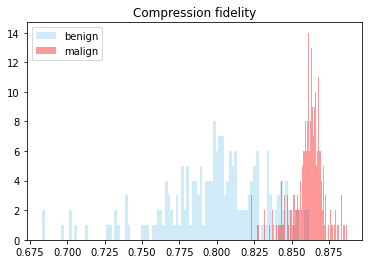

In [41]:
plt.hist(beningn_flist, bins = 100 ,label="benign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="malign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [59]:
split=0.845


print("split:",split)
b_e=[]
for i in beningn_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malignification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.845
benign classification accuracy: 0.9230769230769231
malignification accuracy: 0.9098360655737705
total accuracy: 0.9157175398633257


In [43]:

"""
experiment_parameters={"autoencoder":"e2","params":encoder_params}
f=open("Cancer_encoder_e5-SelectedFeautures-ent_params500"+str(epoch)+".txt","w")
f.write(str(experiment_parameters))
f.close()
"""